In [4]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Commodity universe (Yahoo Finance tickers)
DEFAULT_UNIVERSE = {
    'Energy': ['CL=F', 'BZ=F', 'NG=F', 'RB=F', 'HO=F'],
    'Metals': ['GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F'],  
    'Grain_Oilseeds': ['ZC=F', 'ZW=F', 'KE=F', 'ZS=F', 'ZM=F', 'ZL=F', 'ZO=F'],
    'Softs': ['KC=F', 'SB=F', 'CC=F', 'CT=F', 'OJ=F'],
    'Livestock_Dairy': ['LE=F', 'HE=F', 'GF=F', 'DC=F'],
    'Other': ['LBS=F']
}

ALL_TICKERS = [ticker for category in DEFAULT_UNIVERSE.values() for ticker in category]

# Strategy parameters (modify as needed)
CONFIG = {
    'start_date': '1990-01-01',
    'end_date': '2025-07-31', 
    'ranking_windows': [1, 3, 6, 12, 24, 36],  # R months
    'holding_windows': [1, 3, 6, 12, 24, 36],  # H months
    'strategies': ['momentum', 'contrarian'],   # or ['momentum'] or ['contrarian']
    'n_quintiles': 5,
    'min_history_months': 12,
    'transaction_cost_bps': 0,  # Set to 5-10 for realistic costs
    'risk_free_ticker': '^IRX',
    'tickers': ALL_TICKERS  # Use subset for faster testing: ['CL=F', 'GC=F', 'ZC=F', 'NG=F']
}

print("⚙️ Configuration:")
for key, value in CONFIG.items():
    if isinstance(value, list) and len(value) > 5:
        print(f"   {key}: {value[:3]} ... ({len(value)} items)")
    else:
        print(f"   {key}: {value}")

⚙️ Configuration:
   start_date: 1990-01-01
   end_date: 2025-07-31
   ranking_windows: [1, 3, 6] ... (6 items)
   holding_windows: [1, 3, 6] ... (6 items)
   strategies: ['momentum', 'contrarian']
   n_quintiles: 5
   min_history_months: 12
   transaction_cost_bps: 0
   risk_free_ticker: ^IRX
   tickers: ['CL=F', 'BZ=F', 'NG=F'] ... (27 items)


# Cross-Sectional Momentum & Contrarian Strategies on Commodity Futures

## 📋 Overview

This notebook implements cross-sectional momentum and contrarian strategies on commodity futures following the Jegadeesh-Titman (1993) methodology. The implementation includes:

- Cross-sectional quintile formation with no gap months
- Overlapping portfolio construction for R-H combinations  
- Momentum (R ∈ {1,3,6,12}) and Contrarian (R ∈ {24,36,60}) strategies
- Newey-West t-statistics for overlapping returns
- Comprehensive performance evaluation and visualization

**🚀 Generated with [Claude Code](https://claude.ai/code)**

In [5]:
# Import required libraries
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
from scipy import stats
import json

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("📦 Libraries imported successfully!")
print(f"⏰ Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📦 Libraries imported successfully!
⏰ Notebook started at: 2025-08-10 16:10:08


## 📥 Data Download and Preprocessing

In [6]:
def download_prices(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    """
    Download commodity prices from Yahoo Finance.
    """
    print(f"📥 Downloading prices for {len(tickers)} commodities...")
    print(f"📅 Period: {start} to {end}")
    
    price_data = pd.DataFrame()
    failed_tickers = []
    successful_tickers = []
    
    for ticker in tqdm(tickers, desc="Downloading"):
        try:
            data = yf.download(ticker, start=start, end=end, progress=False)
            
            if data.empty:
                failed_tickers.append(ticker)
                continue
                
            # Use Adj Close if available, otherwise Close
            if 'Adj Close' in data.columns:
                prices = data['Adj Close']
            else:
                prices = data['Close']
            
            if isinstance(prices, pd.DataFrame) and len(prices.columns) == 1:
                prices = prices.iloc[:, 0]
            
            price_data[ticker] = prices
            successful_tickers.append(ticker)
            
        except Exception as e:
            print(f"❌ Failed to download {ticker}: {str(e)}")
            failed_tickers.append(ticker)
            continue
    
    price_data = price_data.dropna(how='all')
    
    print(f"✅ Successfully downloaded {len(successful_tickers)} commodities")
    if failed_tickers:
        print(f"❌ Failed: {failed_tickers}")
    
    return price_data

def to_monthly(df_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Convert daily prices to monthly (month-end) prices.
    """
    print("📅 Converting to month-end prices...")
    monthly_prices = df_prices.groupby(pd.Grouper(freq='M')).last()
    monthly_prices = monthly_prices.dropna(how='all')
    print(f"📊 Monthly data: {len(monthly_prices)} months x {len(monthly_prices.columns)} commodities")
    return monthly_prices

def compute_monthly_returns(df_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Compute monthly log returns.
    """
    print("🔢 Computing monthly log returns...")
    returns = np.log(df_prices / df_prices.shift(1))
    returns = returns.dropna(how='all')
    print(f"📊 Returns: {len(returns)} months x {len(returns.columns)} commodities")
    return returns

# Download data
daily_prices = download_prices(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'])
monthly_prices = to_monthly(daily_prices)
monthly_returns = compute_monthly_returns(monthly_prices)

print(f"\n📈 Final dataset:")
print(f"   Period: {monthly_returns.index.min().date()} to {monthly_returns.index.max().date()}")
print(f"   Commodities: {list(monthly_returns.columns)}")

📥 Downloading prices for 27 commodities...
📅 Period: 1990-01-01 to 2025-07-31


Downloading: 100%|██████████| 27/27 [00:34<00:00,  1.27s/it]

✅ Successfully downloaded 27 commodities
📅 Converting to month-end prices...
📊 Monthly data: 300 months x 27 commodities
🔢 Computing monthly log returns...
📊 Returns: 299 months x 27 commodities

📈 Final dataset:
   Period: 2000-09-30 to 2025-07-31
   Commodities: ['CL=F', 'BZ=F', 'NG=F', 'RB=F', 'HO=F', 'GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'ZC=F', 'ZW=F', 'KE=F', 'ZS=F', 'ZM=F', 'ZL=F', 'ZO=F', 'KC=F', 'SB=F', 'CC=F', 'CT=F', 'OJ=F', 'LE=F', 'HE=F', 'GF=F', 'DC=F', 'LBS=F']


In [7]:
# =============================================================================
# CACHE MANAGEMENT SYSTEM (Optional Quick Start)
# =============================================================================

try:
    # Import cache utilities (if available)
    from cache_utils import load_cached_data, load_strategy_results, get_performance_summary, quick_analysis_report
    from data_cache_manager import DataCacheManager
    CACHE_AVAILABLE = True
    print("🔄 Cache system available!")
    
    # Quick cache status check
    cache_manager = DataCacheManager(".")
    data_cached = cache_manager.download_metadata_file.exists()
    results_exist = Path('./results/series/').exists() and len(list(Path('./results/series/').glob('*_returns.csv'))) > 0
    
    print(f"📥 Data Cache: {'✅ Available' if data_cached else '❌ Not available'}")
    print(f"🏆 Strategy Results: {'✅ Available' if results_exist else '❌ Not available'}")
    
    if data_cached and results_exist:
        print("\n💡 OPTION 1: Load everything from cache (fast)")
        print("   Run: daily_prices, monthly_prices, monthly_returns = load_cached_data()")
        print("   Run: strategy_results = load_strategy_results(top_n=10)")
        print("   Run: summary_df = get_performance_summary()")
        print("\n💡 OPTION 2: Skip to 'Results Analysis' section if cache loaded")
        
    elif data_cached:
        print("\n💡 Load cached data only:")
        print("   Run: daily_prices, monthly_prices, monthly_returns = load_cached_data()")
        print("   Then continue with strategy execution")
    else:
        print("\n💡 No cache found - proceed with full download and analysis")
    
except ImportError:
    CACHE_AVAILABLE = False
    print("📦 Cache system not available - proceeding with standard workflow")

print(f"✅ Cache status: {'Available' if CACHE_AVAILABLE else 'Not available'}")

🔄 Cache system available!
📁 Data Cache Manager initialized
   Data directory: data
   Cache directory: cache
📥 Data Cache: ❌ Not available
🏆 Strategy Results: ✅ Available

💡 No cache found - proceed with full download and analysis
✅ Cache status: Available


## 🔄 Cross-Sectional Strategy Functions

In [8]:
def form_quintiles(signal_scores: pd.Series, n_quintiles: int = 5) -> Dict[int, List[str]]:
    """
    Form quintiles based on cross-sectional ranking.
    
    Returns:
        Dict mapping quintile (1=Losers, 5=Winners) to list of tickers
    """
    valid_scores = signal_scores.dropna()
    
    if len(valid_scores) < n_quintiles:
        return {q: [] for q in range(1, n_quintiles + 1)}
    
    ranks = valid_scores.rank(method='first')
    quintile_size = len(valid_scores) / n_quintiles
    
    quintiles = {}
    for q in range(1, n_quintiles + 1):
        if q == n_quintiles:
            lower_bound = (q - 1) * quintile_size
            mask = ranks > lower_bound
        else:
            lower_bound = (q - 1) * quintile_size
            upper_bound = q * quintile_size
            mask = (ranks > lower_bound) & (ranks <= upper_bound)
        
        quintiles[q] = valid_scores[mask].index.tolist()
    
    return quintiles

def calculate_ranking_signal(returns: pd.DataFrame, date: pd.Timestamp, R: int, 
                           min_hist: int = 12) -> pd.Series:
    """
    Calculate ranking signal for cross-sectional strategy.
    
    Args:
        returns: Monthly returns DataFrame
        date: Current date
        R: Ranking window in months
        min_hist: Minimum history required
    
    Returns:
        Series of signals for eligible assets
    """
    try:
        date_idx = returns.index.get_loc(date)
    except KeyError:
        return pd.Series(dtype=float)
    
    if date_idx < max(R, min_hist):
        return pd.Series(dtype=float)
    
    # Get ranking period (exclude current month - no gap month)
    ranking_start = date_idx - R
    ranking_end = date_idx
    
    ranking_returns = returns.iloc[ranking_start:ranking_end]
    
    # Signal = arithmetic mean of monthly returns over R months
    signals = ranking_returns.mean()
    
    # Filter assets with sufficient history
    valid_assets = []
    for asset in signals.index:
        asset_history = returns.loc[:date, asset].dropna()
        if len(asset_history) >= min_hist:
            valid_assets.append(asset)
    
    return signals[valid_assets]

print("✅ Cross-sectional strategy functions defined")

✅ Cross-sectional strategy functions defined


In [9]:
def run_cs_strategy(returns: pd.DataFrame, R: int, H: int, mode: str = 'momentum',
                   costs_bps: float = 0, min_hist: int = 12, 
                   n_quintiles: int = 5) -> Dict[str, pd.Series]:
    """
    Run cross-sectional strategy with overlapping portfolios.
    
    Args:
        returns: Monthly returns DataFrame
        R: Ranking period in months
        H: Holding period in months
        mode: 'momentum' or 'contrarian'
        costs_bps: Transaction costs in basis points
        min_hist: Minimum history required
        n_quintiles: Number of quintiles
    
    Returns:
        Dictionary with strategy return series
    """
    print(f"🚀 Running {mode} strategy R={R}, H={H}")
    
    # Initialize storage
    cohort_returns = {}
    portfolio_returns = {
        'long_short': [],
        'long_only_q5': [], 
        'equal_weight': []
    }
    
    rebalance_dates = []
    
    # Main strategy loop
    for i, date in enumerate(returns.index):
        if i < max(R, min_hist):
            continue
            
        rebalance_dates.append(date)
        
        # Calculate ranking signals
        signals = calculate_ranking_signal(returns, date, R, min_hist)
        
        if len(signals) < n_quintiles:
            for strategy in portfolio_returns:
                portfolio_returns[strategy].append(0.0)
            continue
        
        # Form quintiles
        quintiles = form_quintiles(signals, n_quintiles)
        
        # Get winners and losers based on strategy mode
        if mode == 'momentum':
            winners = quintiles[5]  # Q5 - highest signals
            losers = quintiles[1]   # Q1 - lowest signals
        else:  # contrarian
            winners = quintiles[1]  # Q1 - lowest signals (buy losers)
            losers = quintiles[5]   # Q5 - highest signals (sell winners)
        
        # Create new cohort
        cohort_key = f"{date.strftime('%Y-%m')}_R{R}H{H}"
        cohort_returns[cohort_key] = {
            'start_date': date,
            'winners': winners,
            'losers': losers,
            'returns': [],
            'active': True
        }
        
        # Calculate portfolio returns for this month
        transaction_cost = costs_bps / 10000.0
        ls_return = 0.0
        lo_return = 0.0
        ew_return = 0.0
        active_cohorts = 0
        
        # Loop through active cohorts
        for cohort_key, cohort_data in cohort_returns.items():
            if not cohort_data['active']:
                continue
                
            months_active = len(cohort_data['returns'])
            if months_active >= H:
                cohort_data['active'] = False
                continue
            
            active_cohorts += 1
            
            if i < len(returns):
                current_month_returns = returns.iloc[i]
                
                # Long-short portfolio
                winner_return = current_month_returns[cohort_data['winners']].mean() if cohort_data['winners'] else 0
                loser_return = current_month_returns[cohort_data['losers']].mean() if cohort_data['losers'] else 0
                
                cohort_ls_return = winner_return - loser_return
                if months_active == 0:  # Apply transaction costs in first month
                    cohort_ls_return -= 2 * transaction_cost
                
                # Long-only Q5
                cohort_lo_return = winner_return
                if months_active == 0:
                    cohort_lo_return -= transaction_cost
                
                # Equal-weight
                all_assets = list(set(cohort_data['winners'] + cohort_data['losers']))
                cohort_ew_return = current_month_returns[all_assets].mean() if all_assets else 0
                if months_active == 0:
                    cohort_ew_return -= transaction_cost
                
                cohort_data['returns'].append({
                    'long_short': cohort_ls_return,
                    'long_only_q5': cohort_lo_return,
                    'equal_weight': cohort_ew_return
                })
                
                ls_return += cohort_ls_return
                lo_return += cohort_lo_return
                ew_return += cohort_ew_return
        
        # Average across active cohorts (overlapping methodology)
        if active_cohorts > 0:
            portfolio_returns['long_short'].append(ls_return / active_cohorts)
            portfolio_returns['long_only_q5'].append(lo_return / active_cohorts)
            portfolio_returns['equal_weight'].append(ew_return / active_cohorts)
        else:
            portfolio_returns['long_short'].append(0.0)
            portfolio_returns['long_only_q5'].append(0.0)
            portfolio_returns['equal_weight'].append(0.0)
    
    # Convert to pandas Series
    result_index = pd.DatetimeIndex(rebalance_dates)
    results = {}
    
    for strategy_type, returns_list in portfolio_returns.items():
        results[strategy_type] = pd.Series(returns_list, index=result_index)
    
    print(f"✅ Completed {mode} R={R}, H={H}: {len(result_index)} periods")
    return results

print("✅ Main strategy function defined")

✅ Main strategy function defined


## 📊 Performance Evaluation

In [10]:
def nw_tstat(returns: pd.Series, lags: int = None) -> float:
    """
    Calculate Newey-West t-statistic for testing if mean return is zero.
    """
    returns_clean = returns.dropna()
    
    if len(returns_clean) < 2:
        return np.nan
    
    n = len(returns_clean)
    mean_ret = returns_clean.mean()
    
    if lags is None:
        lags = max(1, int(np.sqrt(n)))
    
    # Newey-West variance estimator
    gamma_0 = returns_clean.var(ddof=1)
    nw_var = gamma_0
    
    for lag in range(1, min(lags + 1, n)):
        if n - lag > 0:
            gamma_lag = np.cov(returns_clean.iloc[:-lag], returns_clean.iloc[lag:])[0, 1]
            weight = 1 - lag / (lags + 1)  # Bartlett weights
            nw_var += 2 * weight * gamma_lag
    
    nw_se = np.sqrt(nw_var / n)
    
    if nw_se == 0:
        return np.nan
        
    t_stat = mean_ret / nw_se
    return t_stat

def evaluate(returns: pd.Series, rf_rate: pd.Series = None) -> Dict[str, float]:
    """
    Calculate comprehensive performance metrics.
    """
    returns_clean = returns.dropna()
    
    if len(returns_clean) < 2:
        return {metric: np.nan for metric in ['ann_return', 'ann_vol', 'sharpe', 
                                             'hit_ratio', 't_stat', 'max_dd', 'calmar']}
    
    # Basic statistics
    ann_return = returns_clean.mean() * 12
    ann_vol = returns_clean.std() * np.sqrt(12)
    
    # Sharpe ratio
    if rf_rate is not None and len(rf_rate) > 0:
        rf_aligned = rf_rate.reindex(returns_clean.index, method='ffill')
        excess_returns = returns_clean - rf_aligned.fillna(0) / 12
        sharpe = excess_returns.mean() / excess_returns.std() * np.sqrt(12) if excess_returns.std() > 0 else np.nan
    else:
        sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    
    # Hit ratio
    hit_ratio = (returns_clean > 0).mean()
    
    # Newey-West t-statistic
    t_stat = nw_tstat(returns_clean)
    
    # Maximum drawdown
    cumulative = (1 + returns_clean).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    
    # Calmar ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else np.nan
    
    return {
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'hit_ratio': hit_ratio,
        't_stat': t_stat,
        'max_dd': max_dd,
        'calmar': calmar,
        'n_months': len(returns_clean)
    }

print("✅ Performance evaluation functions defined")

✅ Performance evaluation functions defined


## 🔄 Grid Backtest Execution

In [11]:
# Run grid backtest
print("🔄 Starting grid backtest...")
print(f"⚙️ Parameters:")
print(f"   R (ranking): {CONFIG['ranking_windows']}")
print(f"   H (holding): {CONFIG['holding_windows']}")
print(f"   Strategies: {CONFIG['strategies']}")

results = []
detailed_results = {}  # Store return series for top strategies

total_combinations = len(CONFIG['ranking_windows']) * len(CONFIG['holding_windows']) * len(CONFIG['strategies']) * 3
print(f"📊 Total combinations: {total_combinations}")

with tqdm(total=total_combinations, desc="Grid Backtest") as pbar:
    for mode in CONFIG['strategies']:
        for R in CONFIG['ranking_windows']:
            for H in CONFIG['holding_windows']:
                try:
                    # Run strategy
                    strategy_results = run_cs_strategy(
                        monthly_returns, R, H, mode=mode,
                        costs_bps=CONFIG['transaction_cost_bps'],
                        min_hist=CONFIG['min_history_months'],
                        n_quintiles=CONFIG['n_quintiles']
                    )
                    
                    # Evaluate each portfolio type
                    for portfolio_type in ['long_short', 'long_only_q5', 'equal_weight']:
                        if portfolio_type in strategy_results:
                            metrics = evaluate(strategy_results[portfolio_type])
                            
                            strategy_key = f"{mode}_R{R}_H{H}_{portfolio_type}"
                            
                            result_row = {
                                'Strategy': mode.title(),
                                'R': R,
                                'H': H,
                                'Portfolio_Type': portfolio_type,
                                'Strategy_Key': strategy_key,
                                **metrics
                            }
                            
                            results.append(result_row)
                            
                            # Store return series for analysis
                            detailed_results[strategy_key] = strategy_results[portfolio_type]
                        
                        pbar.update(1)
                        
                except Exception as e:
                    print(f"⚠️ Error in {mode} R={R} H={H}: {str(e)}")
                    # Add empty results
                    for portfolio_type in ['long_short', 'long_only_q5', 'equal_weight']:
                        result_row = {
                            'Strategy': mode.title(),
                            'R': R,
                            'H': H,
                            'Portfolio_Type': portfolio_type,
                            'Strategy_Key': f"{mode}_R{R}_H{H}_{portfolio_type}",
                            **{metric: np.nan for metric in ['ann_return', 'ann_vol', 'sharpe',
                                                            'hit_ratio', 't_stat', 'max_dd', 'calmar', 'n_months']}
                        }
                        results.append(result_row)
                        pbar.update(1)

# Convert to DataFrame
summary_df = pd.DataFrame(results)
print(f"\n✅ Grid backtest completed: {len(summary_df)} combinations")
print(f"📊 Valid strategies: {len(summary_df[~summary_df['sharpe'].isna()])}")

🔄 Starting grid backtest...
⚙️ Parameters:
   R (ranking): [1, 3, 6, 12, 24, 36]
   H (holding): [1, 3, 6, 12, 24, 36]
   Strategies: ['momentum', 'contrarian']
📊 Total combinations: 216


Grid Backtest:   0%|          | 0/216 [00:00<?, ?it/s]

🚀 Running momentum strategy R=1, H=1


Grid Backtest:   0%|          | 1/216 [00:02<09:29,  2.65s/it]

✅ Completed momentum R=1, H=1: 287 periods
🚀 Running momentum strategy R=1, H=3


Grid Backtest:   2%|▏         | 4/216 [00:06<05:44,  1.63s/it]

✅ Completed momentum R=1, H=3: 287 periods
🚀 Running momentum strategy R=1, H=6


Grid Backtest:   3%|▎         | 7/216 [00:11<05:41,  1.63s/it]

✅ Completed momentum R=1, H=6: 287 periods
🚀 Running momentum strategy R=1, H=12


Grid Backtest:   5%|▍         | 10/216 [00:17<06:11,  1.80s/it]

✅ Completed momentum R=1, H=12: 287 periods
🚀 Running momentum strategy R=1, H=24


Grid Backtest:   6%|▌         | 13/216 [00:26<07:34,  2.24s/it]

✅ Completed momentum R=1, H=24: 287 periods
🚀 Running momentum strategy R=1, H=36


Grid Backtest:   7%|▋         | 16/216 [00:39<09:49,  2.95s/it]

✅ Completed momentum R=1, H=36: 287 periods
🚀 Running momentum strategy R=3, H=1


Grid Backtest:   9%|▉         | 19/216 [00:42<07:25,  2.26s/it]

✅ Completed momentum R=3, H=1: 287 periods
🚀 Running momentum strategy R=3, H=3


Grid Backtest:  10%|█         | 22/216 [00:45<06:15,  1.93s/it]

✅ Completed momentum R=3, H=3: 287 periods
🚀 Running momentum strategy R=3, H=6


Grid Backtest:  12%|█▏        | 25/216 [00:52<06:18,  1.98s/it]

✅ Completed momentum R=3, H=6: 287 periods
🚀 Running momentum strategy R=3, H=12


Grid Backtest:  13%|█▎        | 28/216 [00:58<06:29,  2.07s/it]

✅ Completed momentum R=3, H=12: 287 periods
🚀 Running momentum strategy R=3, H=24


Grid Backtest:  14%|█▍        | 31/216 [01:08<07:24,  2.40s/it]

✅ Completed momentum R=3, H=24: 287 periods
🚀 Running momentum strategy R=3, H=36


Grid Backtest:  16%|█▌        | 34/216 [01:20<08:40,  2.86s/it]

✅ Completed momentum R=3, H=36: 287 periods
🚀 Running momentum strategy R=6, H=1


Grid Backtest:  17%|█▋        | 37/216 [01:22<06:37,  2.22s/it]

✅ Completed momentum R=6, H=1: 287 periods
🚀 Running momentum strategy R=6, H=3


Grid Backtest:  19%|█▊        | 40/216 [01:25<05:28,  1.87s/it]

✅ Completed momentum R=6, H=3: 287 periods
🚀 Running momentum strategy R=6, H=6


Grid Backtest:  20%|█▉        | 43/216 [01:29<04:50,  1.68s/it]

✅ Completed momentum R=6, H=6: 287 periods
🚀 Running momentum strategy R=6, H=12


Grid Backtest:  21%|██▏       | 46/216 [01:35<05:04,  1.79s/it]

✅ Completed momentum R=6, H=12: 287 periods
🚀 Running momentum strategy R=6, H=24


Grid Backtest:  23%|██▎       | 49/216 [01:46<06:31,  2.34s/it]

✅ Completed momentum R=6, H=24: 287 periods
🚀 Running momentum strategy R=6, H=36


Grid Backtest:  24%|██▍       | 52/216 [01:58<07:47,  2.85s/it]

✅ Completed momentum R=6, H=36: 287 periods
🚀 Running momentum strategy R=12, H=1


Grid Backtest:  25%|██▌       | 55/216 [02:00<05:58,  2.23s/it]

✅ Completed momentum R=12, H=1: 287 periods
🚀 Running momentum strategy R=12, H=3


Grid Backtest:  27%|██▋       | 58/216 [02:03<04:57,  1.88s/it]

✅ Completed momentum R=12, H=3: 287 periods
🚀 Running momentum strategy R=12, H=6


Grid Backtest:  28%|██▊       | 61/216 [02:08<04:30,  1.74s/it]

✅ Completed momentum R=12, H=6: 287 periods
🚀 Running momentum strategy R=12, H=12


Grid Backtest:  30%|██▉       | 64/216 [02:14<04:45,  1.88s/it]

✅ Completed momentum R=12, H=12: 287 periods
🚀 Running momentum strategy R=12, H=24


Grid Backtest:  31%|███       | 67/216 [02:25<05:49,  2.35s/it]

✅ Completed momentum R=12, H=24: 287 periods
🚀 Running momentum strategy R=12, H=36


Grid Backtest:  32%|███▏      | 70/216 [02:37<06:58,  2.87s/it]

✅ Completed momentum R=12, H=36: 287 periods
🚀 Running momentum strategy R=24, H=1


Grid Backtest:  34%|███▍      | 73/216 [02:39<05:24,  2.27s/it]

✅ Completed momentum R=24, H=1: 275 periods
🚀 Running momentum strategy R=24, H=3


Grid Backtest:  35%|███▌      | 76/216 [02:42<04:25,  1.90s/it]

✅ Completed momentum R=24, H=3: 275 periods
🚀 Running momentum strategy R=24, H=6


Grid Backtest:  37%|███▋      | 79/216 [02:47<03:58,  1.74s/it]

✅ Completed momentum R=24, H=6: 275 periods
🚀 Running momentum strategy R=24, H=12


Grid Backtest:  38%|███▊      | 82/216 [02:52<03:56,  1.76s/it]

✅ Completed momentum R=24, H=12: 275 periods
🚀 Running momentum strategy R=24, H=24


Grid Backtest:  39%|███▉      | 85/216 [03:01<04:38,  2.13s/it]

✅ Completed momentum R=24, H=24: 275 periods
🚀 Running momentum strategy R=24, H=36


Grid Backtest:  41%|████      | 88/216 [03:13<05:40,  2.66s/it]

✅ Completed momentum R=24, H=36: 275 periods
🚀 Running momentum strategy R=36, H=1


Grid Backtest:  42%|████▏     | 91/216 [03:15<04:21,  2.09s/it]

✅ Completed momentum R=36, H=1: 263 periods
🚀 Running momentum strategy R=36, H=3


Grid Backtest:  44%|████▎     | 94/216 [03:18<03:36,  1.78s/it]

✅ Completed momentum R=36, H=3: 263 periods
🚀 Running momentum strategy R=36, H=6


Grid Backtest:  45%|████▍     | 97/216 [03:22<03:20,  1.68s/it]

✅ Completed momentum R=36, H=6: 263 periods
🚀 Running momentum strategy R=36, H=12


Grid Backtest:  46%|████▋     | 100/216 [03:29<03:27,  1.79s/it]

✅ Completed momentum R=36, H=12: 263 periods
🚀 Running momentum strategy R=36, H=24


Grid Backtest:  48%|████▊     | 103/216 [03:38<04:07,  2.19s/it]

✅ Completed momentum R=36, H=24: 263 periods
🚀 Running momentum strategy R=36, H=36


Grid Backtest:  49%|████▉     | 106/216 [03:48<04:42,  2.56s/it]

✅ Completed momentum R=36, H=36: 263 periods
🚀 Running contrarian strategy R=1, H=1


Grid Backtest:  50%|█████     | 109/216 [03:51<03:38,  2.04s/it]

✅ Completed contrarian R=1, H=1: 287 periods
🚀 Running contrarian strategy R=1, H=3


Grid Backtest:  52%|█████▏    | 112/216 [03:54<02:58,  1.72s/it]

✅ Completed contrarian R=1, H=3: 287 periods
🚀 Running contrarian strategy R=1, H=6


Grid Backtest:  53%|█████▎    | 115/216 [03:57<02:39,  1.58s/it]

✅ Completed contrarian R=1, H=6: 287 periods
🚀 Running contrarian strategy R=1, H=12


Grid Backtest:  55%|█████▍    | 118/216 [04:03<02:44,  1.68s/it]

✅ Completed contrarian R=1, H=12: 287 periods
🚀 Running contrarian strategy R=1, H=24


Grid Backtest:  56%|█████▌    | 121/216 [04:13<03:21,  2.12s/it]

✅ Completed contrarian R=1, H=24: 287 periods
🚀 Running contrarian strategy R=1, H=36


Grid Backtest:  57%|█████▋    | 124/216 [04:24<04:02,  2.64s/it]

✅ Completed contrarian R=1, H=36: 287 periods
🚀 Running contrarian strategy R=3, H=1


Grid Backtest:  59%|█████▉    | 127/216 [04:27<03:08,  2.12s/it]

✅ Completed contrarian R=3, H=1: 287 periods
🚀 Running contrarian strategy R=3, H=3


Grid Backtest:  60%|██████    | 130/216 [04:30<02:33,  1.79s/it]

✅ Completed contrarian R=3, H=3: 287 periods
🚀 Running contrarian strategy R=3, H=6


Grid Backtest:  62%|██████▏   | 133/216 [04:33<02:12,  1.60s/it]

✅ Completed contrarian R=3, H=6: 287 periods
🚀 Running contrarian strategy R=3, H=12


Grid Backtest:  63%|██████▎   | 136/216 [04:38<02:08,  1.61s/it]

✅ Completed contrarian R=3, H=12: 287 periods
🚀 Running contrarian strategy R=3, H=24


Grid Backtest:  64%|██████▍   | 139/216 [04:46<02:27,  1.92s/it]

✅ Completed contrarian R=3, H=24: 287 periods
🚀 Running contrarian strategy R=3, H=36


Grid Backtest:  66%|██████▌   | 142/216 [04:57<03:01,  2.45s/it]

✅ Completed contrarian R=3, H=36: 287 periods
🚀 Running contrarian strategy R=6, H=1


Grid Backtest:  67%|██████▋   | 145/216 [04:59<02:17,  1.94s/it]

✅ Completed contrarian R=6, H=1: 287 periods
🚀 Running contrarian strategy R=6, H=3


Grid Backtest:  69%|██████▊   | 148/216 [05:02<01:51,  1.64s/it]

✅ Completed contrarian R=6, H=3: 287 periods
🚀 Running contrarian strategy R=6, H=6


Grid Backtest:  70%|██████▉   | 151/216 [05:07<01:41,  1.57s/it]

✅ Completed contrarian R=6, H=6: 287 periods
🚀 Running contrarian strategy R=6, H=12


Grid Backtest:  71%|███████▏  | 154/216 [05:12<01:39,  1.61s/it]

✅ Completed contrarian R=6, H=12: 287 periods
🚀 Running contrarian strategy R=6, H=24


Grid Backtest:  73%|███████▎  | 157/216 [05:20<01:55,  1.95s/it]

✅ Completed contrarian R=6, H=24: 287 periods
🚀 Running contrarian strategy R=6, H=36


Grid Backtest:  74%|███████▍  | 160/216 [05:32<02:26,  2.61s/it]

✅ Completed contrarian R=6, H=36: 287 periods
🚀 Running contrarian strategy R=12, H=1


Grid Backtest:  75%|███████▌  | 163/216 [05:35<01:49,  2.06s/it]

✅ Completed contrarian R=12, H=1: 287 periods
🚀 Running contrarian strategy R=12, H=3


Grid Backtest:  77%|███████▋  | 166/216 [05:38<01:26,  1.74s/it]

✅ Completed contrarian R=12, H=3: 287 periods
🚀 Running contrarian strategy R=12, H=6


Grid Backtest:  78%|███████▊  | 169/216 [05:42<01:15,  1.61s/it]

✅ Completed contrarian R=12, H=6: 287 periods
🚀 Running contrarian strategy R=12, H=12


Grid Backtest:  80%|███████▉  | 172/216 [05:47<01:11,  1.63s/it]

✅ Completed contrarian R=12, H=12: 287 periods
🚀 Running contrarian strategy R=12, H=24


Grid Backtest:  81%|████████  | 175/216 [05:55<01:20,  1.96s/it]

✅ Completed contrarian R=12, H=24: 287 periods
🚀 Running contrarian strategy R=12, H=36


Grid Backtest:  82%|████████▏ | 178/216 [06:06<01:33,  2.47s/it]

✅ Completed contrarian R=12, H=36: 287 periods
🚀 Running contrarian strategy R=24, H=1


Grid Backtest:  84%|████████▍ | 181/216 [06:08<01:08,  1.95s/it]

✅ Completed contrarian R=24, H=1: 275 periods
🚀 Running contrarian strategy R=24, H=3


Grid Backtest:  85%|████████▌ | 184/216 [06:11<00:52,  1.65s/it]

✅ Completed contrarian R=24, H=3: 275 periods
🚀 Running contrarian strategy R=24, H=6


Grid Backtest:  87%|████████▋ | 187/216 [06:14<00:43,  1.50s/it]

✅ Completed contrarian R=24, H=6: 275 periods
🚀 Running contrarian strategy R=24, H=12


Grid Backtest:  88%|████████▊ | 190/216 [06:19<00:39,  1.53s/it]

✅ Completed contrarian R=24, H=12: 275 periods
🚀 Running contrarian strategy R=24, H=24


Grid Backtest:  89%|████████▉ | 193/216 [06:27<00:42,  1.84s/it]

✅ Completed contrarian R=24, H=24: 275 periods
🚀 Running contrarian strategy R=24, H=36


Grid Backtest:  91%|█████████ | 196/216 [06:37<00:46,  2.30s/it]

✅ Completed contrarian R=24, H=36: 275 periods
🚀 Running contrarian strategy R=36, H=1


Grid Backtest:  92%|█████████▏| 199/216 [06:39<00:30,  1.82s/it]

✅ Completed contrarian R=36, H=1: 263 periods
🚀 Running contrarian strategy R=36, H=3


Grid Backtest:  94%|█████████▎| 202/216 [06:42<00:21,  1.53s/it]

✅ Completed contrarian R=36, H=3: 263 periods
🚀 Running contrarian strategy R=36, H=6


Grid Backtest:  95%|█████████▍| 205/216 [06:45<00:15,  1.38s/it]

✅ Completed contrarian R=36, H=6: 263 periods
🚀 Running contrarian strategy R=36, H=12


Grid Backtest:  96%|█████████▋| 208/216 [06:49<00:11,  1.45s/it]

✅ Completed contrarian R=36, H=12: 263 periods
🚀 Running contrarian strategy R=36, H=24


Grid Backtest:  98%|█████████▊| 211/216 [06:56<00:08,  1.71s/it]

✅ Completed contrarian R=36, H=24: 263 periods
🚀 Running contrarian strategy R=36, H=36


Grid Backtest: 100%|██████████| 216/216 [07:05<00:00,  1.97s/it]

✅ Completed contrarian R=36, H=36: 263 periods

✅ Grid backtest completed: 216 combinations
📊 Valid strategies: 216


In [12]:
# =============================================================================
# DATA VALIDATION BEFORE GRID SEARCH
# =============================================================================

print("🔍 Validating data before running grid search...")

# Check if data variables exist and are valid
data_valid = True
required_vars = ['daily_prices', 'monthly_prices', 'monthly_returns']

for var_name in required_vars:
    if var_name not in locals() or locals()[var_name] is None:
        print(f"❌ {var_name} is missing or None")
        data_valid = False
    elif hasattr(locals()[var_name], 'empty') and locals()[var_name].empty:
        print(f"❌ {var_name} is empty")
        data_valid = False
    else:
        data = locals()[var_name]
        print(f"✅ {var_name}: {len(data)} rows x {len(data.columns)} columns")

if not data_valid:
    print("\n❌ Data validation failed!")
    print("💡 Make sure to run the 'Data Download and Preprocessing' section first.")
    print("🛑 Stopping grid search execution.")
    
    # Create empty results to prevent errors
    results = []
    detailed_results = {}
    summary_df = pd.DataFrame()
else:
    print(f"\n✅ Data validation passed!")
    print(f"📊 Ready to run grid search with {len(monthly_returns.columns)} commodities")
    print(f"📅 Period: {monthly_returns.index.min().date()} to {monthly_returns.index.max().date()}")

    # Optional: Save data to cache after validation
    if CACHE_AVAILABLE and data_valid:
        try:
            cache_manager.save_price_data(
                daily_prices=daily_prices,
                monthly_prices=monthly_prices,
                monthly_returns=monthly_returns,
                tickers=CONFIG['tickers'],
                start_date=CONFIG['start_date'],
                end_date=CONFIG['end_date']
            )
            print("💾 Data saved to cache for future runs!")
        except Exception as e:
            print(f"⚠️ Cache save failed: {e}")

🔍 Validating data before running grid search...
✅ daily_prices: 6260 rows x 27 columns
✅ monthly_prices: 300 rows x 27 columns
✅ monthly_returns: 299 rows x 27 columns

✅ Data validation passed!
📊 Ready to run grid search with 27 commodities
📅 Period: 2000-09-30 to 2025-07-31
💾 Saving price data to cache...
✅ Cached 27 commodities
   Daily: 6260 observations
   Monthly: 300 observations
   Returns: 299 observations
💾 Data saved to cache for future runs!


In [19]:
# =============================================================================
# GRID BACKTEST EXECUTION (Only if data is valid)
# =============================================================================

if 'data_valid' in locals() and data_valid:
    print("🔄 Starting grid backtest...")
    print(f"⚙️ Parameters:")
    print(f"   R (ranking): {CONFIG['ranking_windows']}")
    print(f"   H (holding): {CONFIG['holding_windows']}")
    print(f"   Strategies: {CONFIG['strategies']}")

    results = []
    detailed_results = {}  # Store return series for top strategies

    total_combinations = len(CONFIG['ranking_windows']) * len(CONFIG['holding_windows']) * len(CONFIG['strategies']) * 3
    print(f"📊 Total combinations: {total_combinations}")

    with tqdm(total=total_combinations, desc="Grid Backtest") as pbar:
        for mode in CONFIG['strategies']:
            for R in CONFIG['ranking_windows']:
                for H in CONFIG['holding_windows']:
                    try:
                        # Run strategy
                        strategy_results = run_cs_strategy(
                            monthly_returns, R, H, mode=mode,
                            costs_bps=CONFIG['transaction_cost_bps'],
                            min_hist=CONFIG['min_history_months'],
                            n_quintiles=CONFIG['n_quintiles']
                        )
                        
                        # Evaluate each portfolio type
                        for portfolio_type in ['long_short', 'long_only_q5', 'equal_weight']:
                            if portfolio_type in strategy_results:
                                metrics = evaluate(strategy_results[portfolio_type])
                                
                                strategy_key = f"{mode}_R{R}_H{H}_{portfolio_type}"
                                
                                result_row = {
                                    'Strategy': mode.title(),
                                    'R': R,
                                    'H': H,
                                    'Portfolio_Type': portfolio_type,
                                    'Strategy_Key': strategy_key,
                                    **metrics
                                }
                                
                                results.append(result_row)
                                
                                # Store return series for analysis
                                detailed_results[strategy_key] = strategy_results[portfolio_type]
                            
                            pbar.update(1)
                            
                    except Exception as e:
                        print(f"⚠️ Error in {mode} R={R} H={H}: {str(e)}")
                        # Add empty results
                        for portfolio_type in ['long_short', 'long_only_q5', 'equal_weight']:
                            result_row = {
                                'Strategy': mode.title(),
                                'R': R,
                                'H': H,
                                'Portfolio_Type': portfolio_type,
                                'Strategy_Key': f"{mode}_R{R}_H{H}_{portfolio_type}",
                                **{metric: np.nan for metric in ['ann_return', 'ann_vol', 'sharpe',
                                                                'hit_ratio', 't_stat', 'max_dd', 'calmar', 'n_months']}
                            }
                            results.append(result_row)
                            pbar.update(1)

    # Convert to DataFrame
    summary_df = pd.DataFrame(results)
    print(f"\n✅ Grid backtest completed: {len(summary_df)} combinations")
    print(f"📊 Valid strategies: {len(summary_df[~summary_df['sharpe'].isna()])}")

else:
    print("⚠️ Skipping grid backtest - data validation failed")
    print("💡 Use existing results instead:")
    
    # Try to load existing results
    if CACHE_AVAILABLE:
        try:
            summary_df = get_performance_summary()
            if summary_df is not None:
                print(f"✅ Loaded {len(summary_df)} existing strategies from cache")
                detailed_results = {}  # Could load these too if needed
            else:
                print("❌ No existing results available")
                summary_df = pd.DataFrame()
                detailed_results = {}
        except Exception as e:
            print(f"❌ Failed to load existing results: {e}")
            summary_df = pd.DataFrame()
            detailed_results = {}

🔄 Starting grid backtest...
⚙️ Parameters:
   R (ranking): [1, 3, 6, 12, 24, 36]
   H (holding): [1, 3, 6, 12, 24, 36]
   Strategies: ['momentum', 'contrarian']
📊 Total combinations: 216


Grid Backtest:   0%|          | 0/216 [00:00<?, ?it/s]

🚀 Running momentum strategy R=1, H=1


Grid Backtest:   0%|          | 1/216 [00:02<10:44,  3.00s/it]

✅ Completed momentum R=1, H=1: 287 periods
🚀 Running momentum strategy R=1, H=3


Grid Backtest:   2%|▏         | 4/216 [00:07<06:27,  1.83s/it]

✅ Completed momentum R=1, H=3: 287 periods
🚀 Running momentum strategy R=1, H=6


Grid Backtest:   3%|▎         | 7/216 [00:12<05:44,  1.65s/it]

✅ Completed momentum R=1, H=6: 287 periods
🚀 Running momentum strategy R=1, H=12


Grid Backtest:   5%|▍         | 10/216 [00:18<06:22,  1.86s/it]

✅ Completed momentum R=1, H=12: 287 periods
🚀 Running momentum strategy R=1, H=24


Grid Backtest:   6%|▌         | 13/216 [00:27<07:56,  2.35s/it]

✅ Completed momentum R=1, H=24: 287 periods
🚀 Running momentum strategy R=1, H=36


Grid Backtest:   7%|▋         | 16/216 [00:40<10:00,  3.00s/it]

✅ Completed momentum R=1, H=36: 287 periods
🚀 Running momentum strategy R=3, H=1


Grid Backtest:   9%|▉         | 19/216 [00:43<07:40,  2.34s/it]

✅ Completed momentum R=3, H=1: 287 periods
🚀 Running momentum strategy R=3, H=3


Grid Backtest:  10%|█         | 22/216 [00:46<06:15,  1.94s/it]

✅ Completed momentum R=3, H=3: 287 periods
🚀 Running momentum strategy R=3, H=6


Grid Backtest:  12%|█▏        | 25/216 [00:50<05:26,  1.71s/it]

✅ Completed momentum R=3, H=6: 287 periods
🚀 Running momentum strategy R=3, H=12


Grid Backtest:  13%|█▎        | 28/216 [00:55<05:18,  1.70s/it]

✅ Completed momentum R=3, H=12: 287 periods
🚀 Running momentum strategy R=3, H=24


Grid Backtest:  14%|█▍        | 31/216 [01:02<05:57,  1.93s/it]

✅ Completed momentum R=3, H=24: 287 periods
🚀 Running momentum strategy R=3, H=36


Grid Backtest:  16%|█▌        | 34/216 [01:14<07:40,  2.53s/it]

✅ Completed momentum R=3, H=36: 287 periods
🚀 Running momentum strategy R=6, H=1


Grid Backtest:  17%|█▋        | 37/216 [01:17<06:15,  2.10s/it]

✅ Completed momentum R=6, H=1: 287 periods
🚀 Running momentum strategy R=6, H=3


Grid Backtest:  19%|█▊        | 40/216 [01:21<05:14,  1.79s/it]

✅ Completed momentum R=6, H=3: 287 periods
🚀 Running momentum strategy R=6, H=6


Grid Backtest:  20%|█▉        | 43/216 [01:25<04:42,  1.64s/it]

✅ Completed momentum R=6, H=6: 287 periods
🚀 Running momentum strategy R=6, H=12


Grid Backtest:  21%|██▏       | 46/216 [01:32<05:15,  1.85s/it]

✅ Completed momentum R=6, H=12: 287 periods
🚀 Running momentum strategy R=6, H=24


Grid Backtest:  23%|██▎       | 49/216 [01:41<06:21,  2.28s/it]

✅ Completed momentum R=6, H=24: 287 periods
🚀 Running momentum strategy R=6, H=36


Grid Backtest:  24%|██▍       | 52/216 [01:55<08:12,  3.00s/it]

✅ Completed momentum R=6, H=36: 287 periods
🚀 Running momentum strategy R=12, H=1


Grid Backtest:  25%|██▌       | 55/216 [01:58<06:16,  2.34s/it]

✅ Completed momentum R=12, H=1: 287 periods
🚀 Running momentum strategy R=12, H=3


Grid Backtest:  27%|██▋       | 58/216 [02:01<05:10,  1.96s/it]

✅ Completed momentum R=12, H=3: 287 periods
🚀 Running momentum strategy R=12, H=6


Grid Backtest:  28%|██▊       | 61/216 [02:05<04:31,  1.75s/it]

✅ Completed momentum R=12, H=6: 287 periods
🚀 Running momentum strategy R=12, H=12


Grid Backtest:  30%|██▉       | 64/216 [02:11<04:43,  1.86s/it]

✅ Completed momentum R=12, H=12: 287 periods
🚀 Running momentum strategy R=12, H=24


Grid Backtest:  31%|███       | 67/216 [02:22<05:50,  2.35s/it]

✅ Completed momentum R=12, H=24: 287 periods
🚀 Running momentum strategy R=12, H=36


Grid Backtest:  32%|███▏      | 70/216 [02:35<07:21,  3.02s/it]

✅ Completed momentum R=12, H=36: 287 periods
🚀 Running momentum strategy R=24, H=1


Grid Backtest:  34%|███▍      | 73/216 [02:38<05:35,  2.35s/it]

✅ Completed momentum R=24, H=1: 275 periods
🚀 Running momentum strategy R=24, H=3


Grid Backtest:  35%|███▌      | 76/216 [02:41<04:34,  1.96s/it]

✅ Completed momentum R=24, H=3: 275 periods
🚀 Running momentum strategy R=24, H=6


Grid Backtest:  37%|███▋      | 79/216 [02:45<04:01,  1.76s/it]

✅ Completed momentum R=24, H=6: 275 periods
🚀 Running momentum strategy R=24, H=12


Grid Backtest:  38%|███▊      | 82/216 [02:51<04:00,  1.79s/it]

✅ Completed momentum R=24, H=12: 275 periods
🚀 Running momentum strategy R=24, H=24


Grid Backtest:  39%|███▉      | 85/216 [03:01<04:57,  2.27s/it]

✅ Completed momentum R=24, H=24: 275 periods
🚀 Running momentum strategy R=24, H=36


Grid Backtest:  41%|████      | 88/216 [03:14<06:15,  2.93s/it]

✅ Completed momentum R=24, H=36: 275 periods
🚀 Running momentum strategy R=36, H=1


Grid Backtest:  42%|████▏     | 91/216 [03:16<04:46,  2.29s/it]

✅ Completed momentum R=36, H=1: 263 periods
🚀 Running momentum strategy R=36, H=3


Grid Backtest:  44%|████▎     | 94/216 [03:20<04:00,  1.97s/it]

✅ Completed momentum R=36, H=3: 263 periods
🚀 Running momentum strategy R=36, H=6


Grid Backtest:  45%|████▍     | 97/216 [03:25<03:37,  1.82s/it]

✅ Completed momentum R=36, H=6: 263 periods
🚀 Running momentum strategy R=36, H=12


Grid Backtest:  46%|████▋     | 100/216 [03:30<03:33,  1.84s/it]

✅ Completed momentum R=36, H=12: 263 periods
🚀 Running momentum strategy R=36, H=24


Grid Backtest:  48%|████▊     | 103/216 [03:39<04:04,  2.17s/it]

✅ Completed momentum R=36, H=24: 263 periods
🚀 Running momentum strategy R=36, H=36


Grid Backtest:  49%|████▉     | 106/216 [03:52<05:12,  2.84s/it]

✅ Completed momentum R=36, H=36: 263 periods
🚀 Running contrarian strategy R=1, H=1


Grid Backtest:  50%|█████     | 109/216 [03:55<04:06,  2.30s/it]

✅ Completed contrarian R=1, H=1: 287 periods
🚀 Running contrarian strategy R=1, H=3


Grid Backtest:  52%|█████▏    | 112/216 [03:59<03:22,  1.95s/it]

✅ Completed contrarian R=1, H=3: 287 periods
🚀 Running contrarian strategy R=1, H=6


Grid Backtest:  53%|█████▎    | 115/216 [04:03<02:58,  1.77s/it]

✅ Completed contrarian R=1, H=6: 287 periods
🚀 Running contrarian strategy R=1, H=12


Grid Backtest:  55%|█████▍    | 118/216 [04:09<02:59,  1.83s/it]

✅ Completed contrarian R=1, H=12: 287 periods
🚀 Running contrarian strategy R=1, H=24


Grid Backtest:  56%|█████▌    | 121/216 [04:18<03:29,  2.21s/it]

✅ Completed contrarian R=1, H=24: 287 periods
🚀 Running contrarian strategy R=1, H=36


Grid Backtest:  57%|█████▋    | 124/216 [04:31<04:24,  2.87s/it]

✅ Completed contrarian R=1, H=36: 287 periods
🚀 Running contrarian strategy R=3, H=1


Grid Backtest:  59%|█████▉    | 127/216 [04:34<03:21,  2.26s/it]

✅ Completed contrarian R=3, H=1: 287 periods
🚀 Running contrarian strategy R=3, H=3


Grid Backtest:  60%|██████    | 130/216 [04:38<02:49,  1.97s/it]

✅ Completed contrarian R=3, H=3: 287 periods
🚀 Running contrarian strategy R=3, H=6


Grid Backtest:  62%|██████▏   | 133/216 [04:42<02:29,  1.80s/it]

✅ Completed contrarian R=3, H=6: 287 periods
🚀 Running contrarian strategy R=3, H=12


Grid Backtest:  63%|██████▎   | 136/216 [04:48<02:32,  1.91s/it]

✅ Completed contrarian R=3, H=12: 287 periods
🚀 Running contrarian strategy R=3, H=24


Grid Backtest:  64%|██████▍   | 139/216 [04:59<03:02,  2.37s/it]

✅ Completed contrarian R=3, H=24: 287 periods
🚀 Running contrarian strategy R=3, H=36


Grid Backtest:  66%|██████▌   | 142/216 [05:12<03:41,  3.00s/it]

✅ Completed contrarian R=3, H=36: 287 periods
🚀 Running contrarian strategy R=6, H=1


Grid Backtest:  67%|██████▋   | 145/216 [05:14<02:44,  2.31s/it]

✅ Completed contrarian R=6, H=1: 287 periods
🚀 Running contrarian strategy R=6, H=3


Grid Backtest:  69%|██████▊   | 148/216 [05:17<02:07,  1.88s/it]

✅ Completed contrarian R=6, H=3: 287 periods
🚀 Running contrarian strategy R=6, H=6


Grid Backtest:  70%|██████▉   | 151/216 [05:21<01:54,  1.76s/it]

✅ Completed contrarian R=6, H=6: 287 periods
🚀 Running contrarian strategy R=6, H=12


Grid Backtest:  71%|███████▏  | 154/216 [05:28<02:00,  1.94s/it]

✅ Completed contrarian R=6, H=12: 287 periods
🚀 Running contrarian strategy R=6, H=24


Grid Backtest:  73%|███████▎  | 157/216 [05:37<02:13,  2.27s/it]

✅ Completed contrarian R=6, H=24: 287 periods
🚀 Running contrarian strategy R=6, H=36


Grid Backtest:  74%|███████▍  | 160/216 [05:50<02:39,  2.84s/it]

✅ Completed contrarian R=6, H=36: 287 periods
🚀 Running contrarian strategy R=12, H=1


Grid Backtest:  75%|███████▌  | 163/216 [05:52<01:58,  2.23s/it]

✅ Completed contrarian R=12, H=1: 287 periods
🚀 Running contrarian strategy R=12, H=3


Grid Backtest:  77%|███████▋  | 166/216 [05:55<01:32,  1.86s/it]

✅ Completed contrarian R=12, H=3: 287 periods
🚀 Running contrarian strategy R=12, H=6


Grid Backtest:  78%|███████▊  | 169/216 [05:59<01:19,  1.68s/it]

✅ Completed contrarian R=12, H=6: 287 periods
🚀 Running contrarian strategy R=12, H=12


Grid Backtest:  80%|███████▉  | 172/216 [06:06<01:21,  1.85s/it]

✅ Completed contrarian R=12, H=12: 287 periods
🚀 Running contrarian strategy R=12, H=24


Grid Backtest:  81%|████████  | 175/216 [06:15<01:28,  2.17s/it]

✅ Completed contrarian R=12, H=24: 287 periods
🚀 Running contrarian strategy R=12, H=36


Grid Backtest:  82%|████████▏ | 178/216 [06:25<01:35,  2.52s/it]

✅ Completed contrarian R=12, H=36: 287 periods
🚀 Running contrarian strategy R=24, H=1


Grid Backtest:  84%|████████▍ | 181/216 [06:27<01:08,  1.97s/it]

✅ Completed contrarian R=24, H=1: 275 periods
🚀 Running contrarian strategy R=24, H=3


Grid Backtest:  85%|████████▌ | 184/216 [06:29<00:51,  1.62s/it]

✅ Completed contrarian R=24, H=3: 275 periods
🚀 Running contrarian strategy R=24, H=6


Grid Backtest:  87%|████████▋ | 187/216 [06:32<00:42,  1.46s/it]

✅ Completed contrarian R=24, H=6: 275 periods
🚀 Running contrarian strategy R=24, H=12


Grid Backtest:  88%|████████▊ | 190/216 [06:38<00:40,  1.57s/it]

✅ Completed contrarian R=24, H=12: 275 periods
🚀 Running contrarian strategy R=24, H=24


Grid Backtest:  89%|████████▉ | 193/216 [06:47<00:45,  1.98s/it]

✅ Completed contrarian R=24, H=24: 275 periods
🚀 Running contrarian strategy R=24, H=36


Grid Backtest:  91%|█████████ | 196/216 [06:59<00:52,  2.61s/it]

✅ Completed contrarian R=24, H=36: 275 periods
🚀 Running contrarian strategy R=36, H=1


Grid Backtest:  92%|█████████▏| 199/216 [07:01<00:35,  2.07s/it]

✅ Completed contrarian R=36, H=1: 263 periods
🚀 Running contrarian strategy R=36, H=3


Grid Backtest:  94%|█████████▎| 202/216 [07:04<00:24,  1.74s/it]

✅ Completed contrarian R=36, H=3: 263 periods
🚀 Running contrarian strategy R=36, H=6


Grid Backtest:  95%|█████████▍| 205/216 [07:08<00:17,  1.63s/it]

✅ Completed contrarian R=36, H=6: 263 periods
🚀 Running contrarian strategy R=36, H=12


Grid Backtest:  96%|█████████▋| 208/216 [07:13<00:13,  1.64s/it]

✅ Completed contrarian R=36, H=12: 263 periods
🚀 Running contrarian strategy R=36, H=24


Grid Backtest:  98%|█████████▊| 211/216 [07:22<00:10,  2.00s/it]

✅ Completed contrarian R=36, H=24: 263 periods
🚀 Running contrarian strategy R=36, H=36


Grid Backtest: 100%|██████████| 216/216 [07:32<00:00,  2.10s/it]

✅ Completed contrarian R=36, H=36: 263 periods

✅ Grid backtest completed: 216 combinations
📊 Valid strategies: 216


In [13]:
# Display top strategies
print("🏆 TOP 10 STRATEGIES BY SHARPE RATIO")
print("=" * 60)

top_10 = summary_df.nlargest(10, 'sharpe')
display_cols = ['Strategy_Key', 'R', 'H', 'Portfolio_Type', 'ann_return', 'sharpe', 't_stat', 'max_dd']

for i, (_, row) in enumerate(top_10.iterrows(), 1):
    print(f"{i:2d}. {row['Strategy_Key']}")
    print(f"     📊 Ann Return: {row['ann_return']:.2%}")
    print(f"     📈 Sharpe: {row['sharpe']:.3f}")
    print(f"     🧮 t-stat: {row['t_stat']:.2f}")
    print(f"     📉 Max DD: {row['max_dd']:.2%}")
    print()

# Summary statistics by strategy type
print("\n📊 SUMMARY BY STRATEGY TYPE")
print("=" * 40)

strategy_summary = summary_df.groupby(['Strategy', 'Portfolio_Type']).agg({
    'ann_return': ['mean', 'std', 'min', 'max'],
    'sharpe': ['mean', 'std', 'min', 'max'],
    't_stat': ['mean', 'std']
}).round(3)

display(strategy_summary)

🏆 TOP 10 STRATEGIES BY SHARPE RATIO
 1. contrarian_R36_H1_long_short
     📊 Ann Return: 26.52%
     📈 Sharpe: 1.048
     🧮 t-stat: 5.65
     📉 Max DD: -35.30%

 2. contrarian_R24_H24_long_short
     📊 Ann Return: 17.03%
     📈 Sharpe: 1.045
     🧮 t-stat: 6.61
     📉 Max DD: -20.31%

 3. contrarian_R36_H24_long_short
     📊 Ann Return: 17.97%
     📈 Sharpe: 1.029
     🧮 t-stat: 6.84
     📉 Max DD: -17.58%

 4. contrarian_R24_H36_long_short
     📊 Ann Return: 13.22%
     📈 Sharpe: 1.029
     🧮 t-stat: 6.49
     📉 Max DD: -13.51%

 5. contrarian_R36_H12_long_short
     📊 Ann Return: 20.82%
     📈 Sharpe: 0.997
     🧮 t-stat: 6.15
     📉 Max DD: -34.32%

 6. contrarian_R36_H6_long_short
     📊 Ann Return: 21.83%
     📈 Sharpe: 0.982
     🧮 t-stat: 5.52
     📉 Max DD: -33.49%

 7. contrarian_R36_H3_long_short
     📊 Ann Return: 22.61%
     📈 Sharpe: 0.956
     🧮 t-stat: 5.42
     📉 Max DD: -33.44%

 8. contrarian_R6_H3_long_short
     📊 Ann Return: 21.58%
     📈 Sharpe: 0.927
     🧮 t-stat

ann_return                      sharpe         \
                                mean    std    min    max   mean    std   
Strategy   Portfolio_Type                                                 
Contrarian equal_weight        0.034  0.005  0.022  0.048  0.211  0.034   
           long_only_q5        0.104  0.035  0.050  0.174  0.565  0.169   
           long_short          0.132  0.064  0.031  0.265  0.755  0.182   
Momentum   equal_weight        0.034  0.005  0.022  0.048  0.211  0.034   
           long_only_q5       -0.028  0.031 -0.091  0.020 -0.135  0.156   
           long_short         -0.132  0.064 -0.265 -0.031 -0.755  0.182   

                                        t_stat         
                             min    max   mean    std  
Strategy   Portfolio_Type                              
Contrarian equal_weight    0.130  0.285  1.013  0.138  
           long_only_q5    0.318  0.887  2.740  0.786  
           long_short      0.363  1.048  4.906  1.599  
Momentum   equal_weight    0.130  0.285  1.013  0.138  
           long_only_q5   -0.424  0.126 -0.742  0.842  
           long_short     -1.048 -0.363 -4.906  1.599

## 📈 Visualizations


📊 Momentum - Long Short - Sharpe Ratio


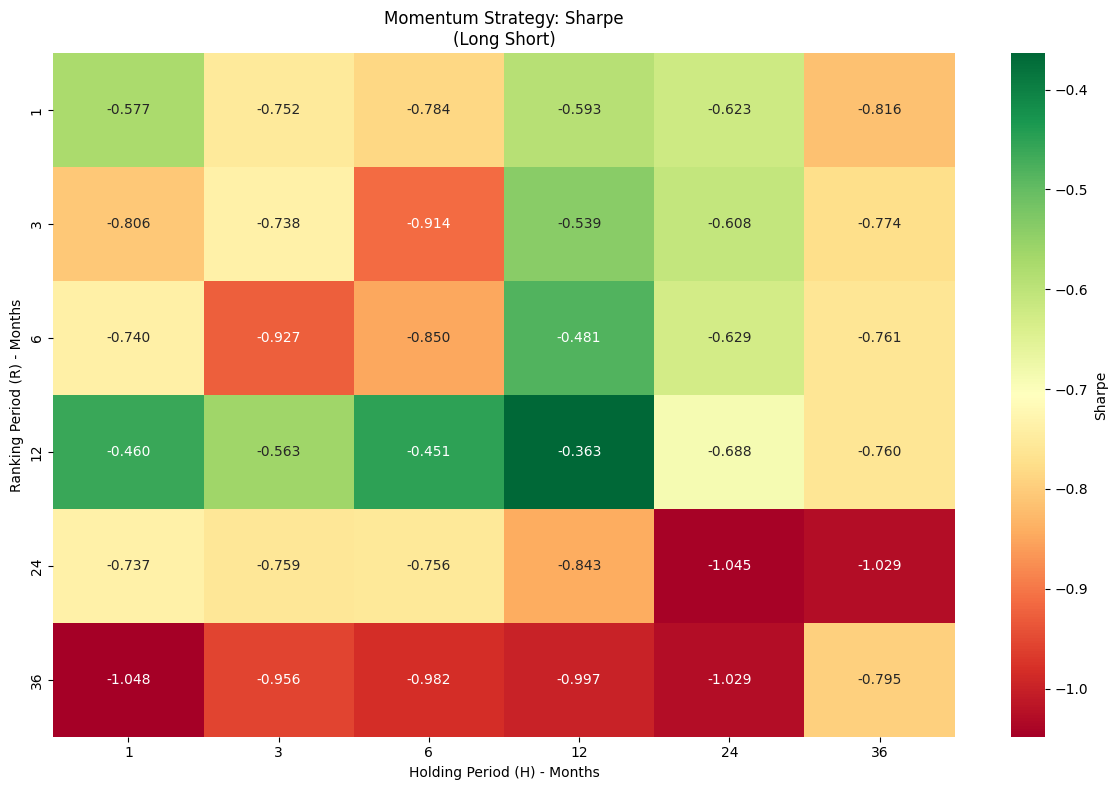


🧮 Momentum - Long Short - t-statistic


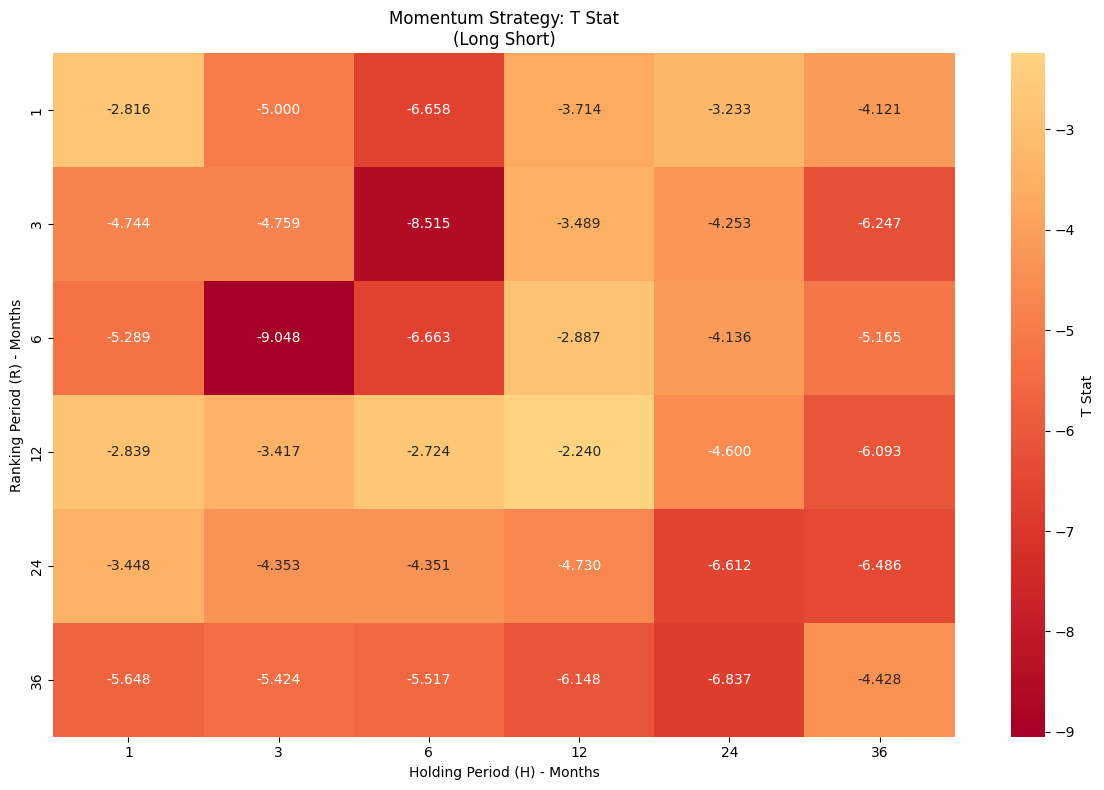


📊 Momentum - Long Only Q5 - Sharpe Ratio


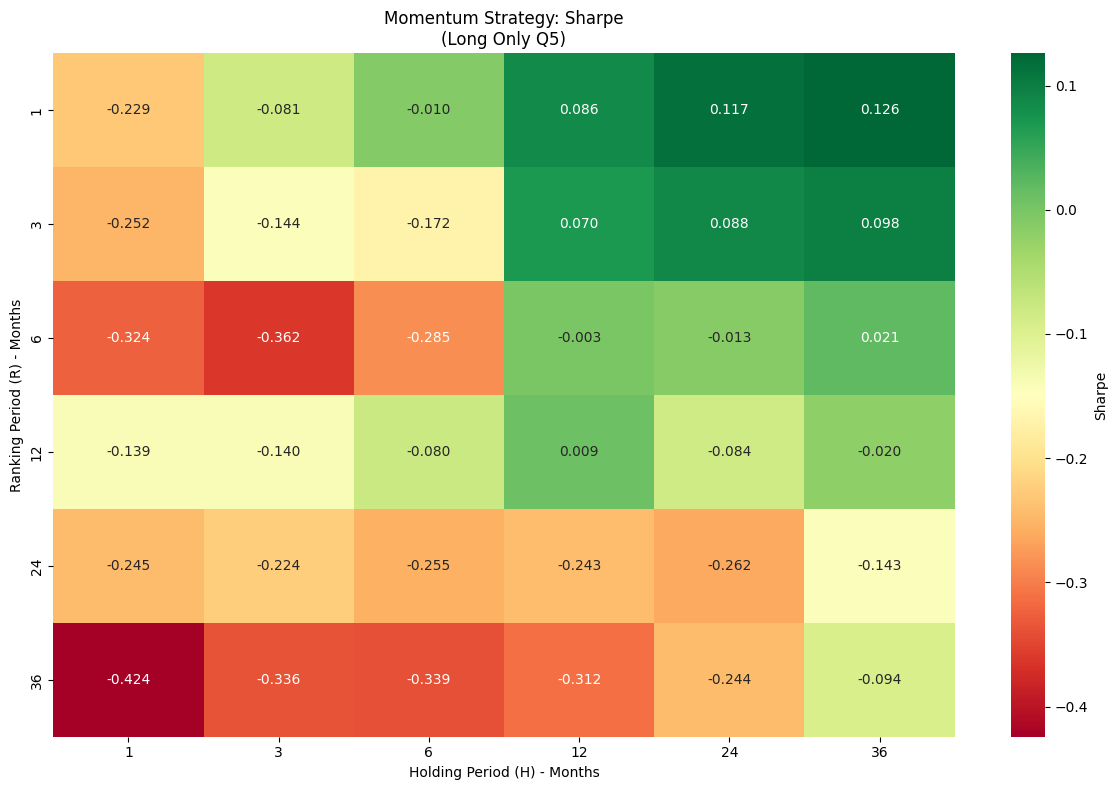


🧮 Momentum - Long Only Q5 - t-statistic


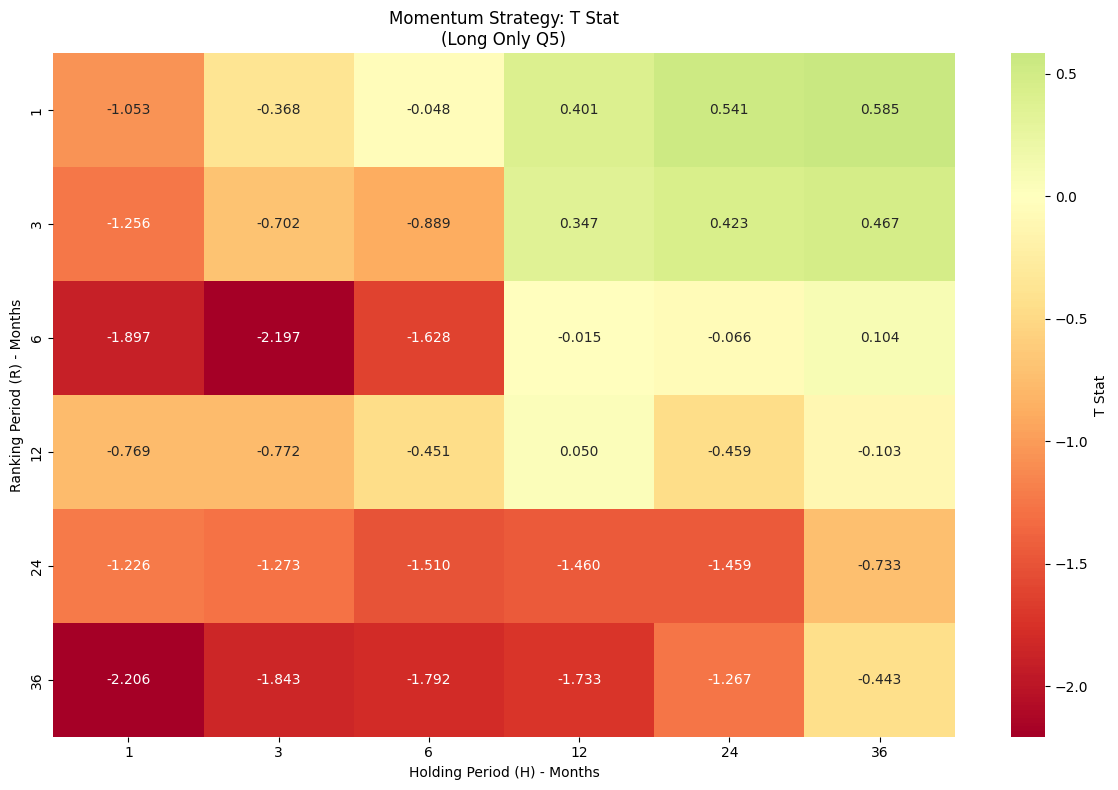


📊 Contrarian - Long Short - Sharpe Ratio


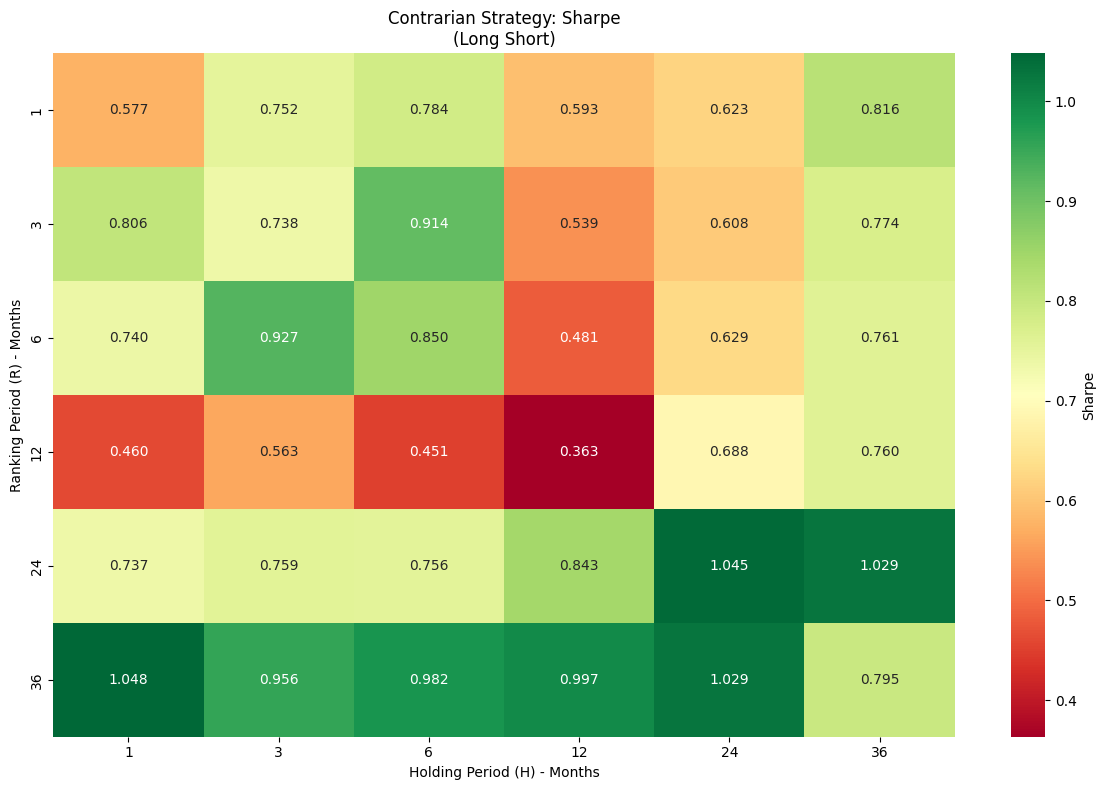


🧮 Contrarian - Long Short - t-statistic


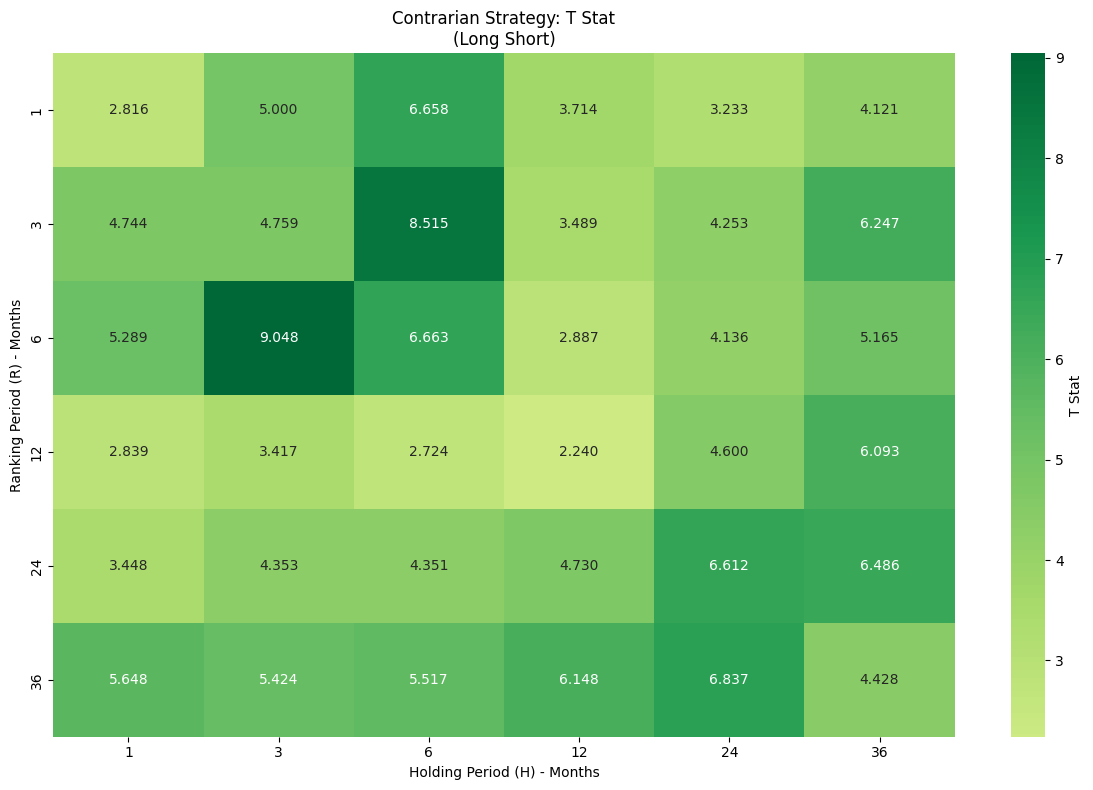


📊 Contrarian - Long Only Q5 - Sharpe Ratio


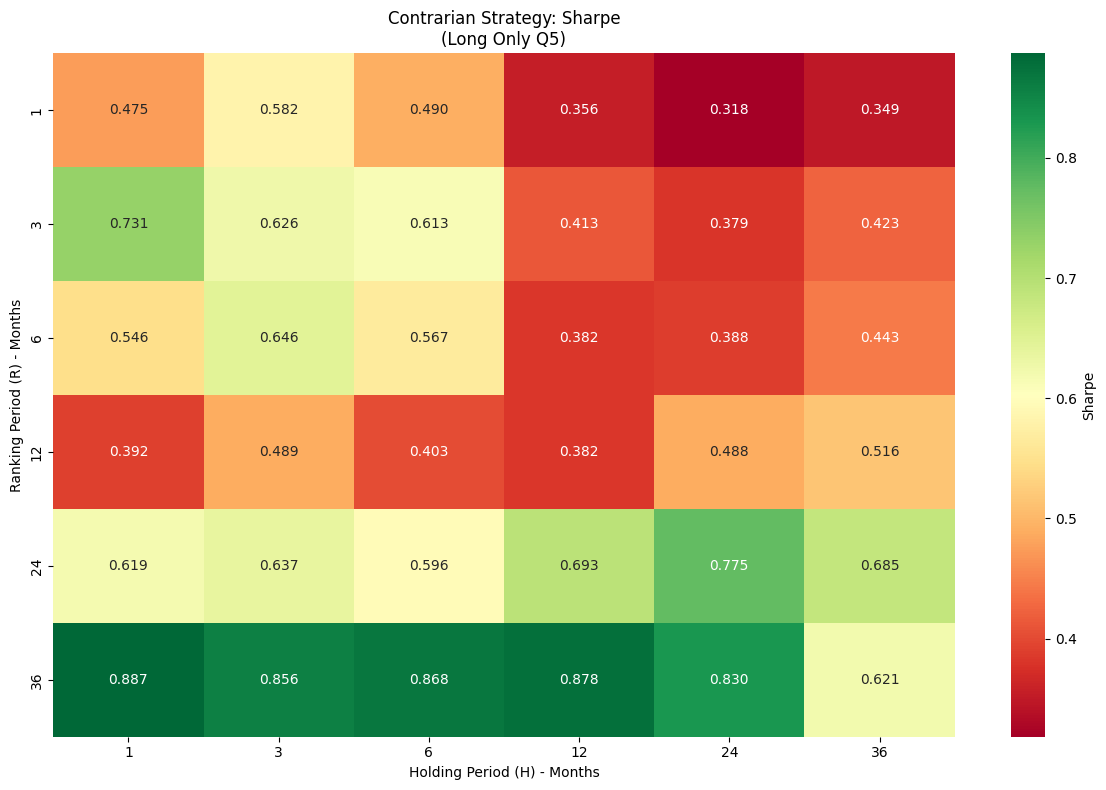


🧮 Contrarian - Long Only Q5 - t-statistic


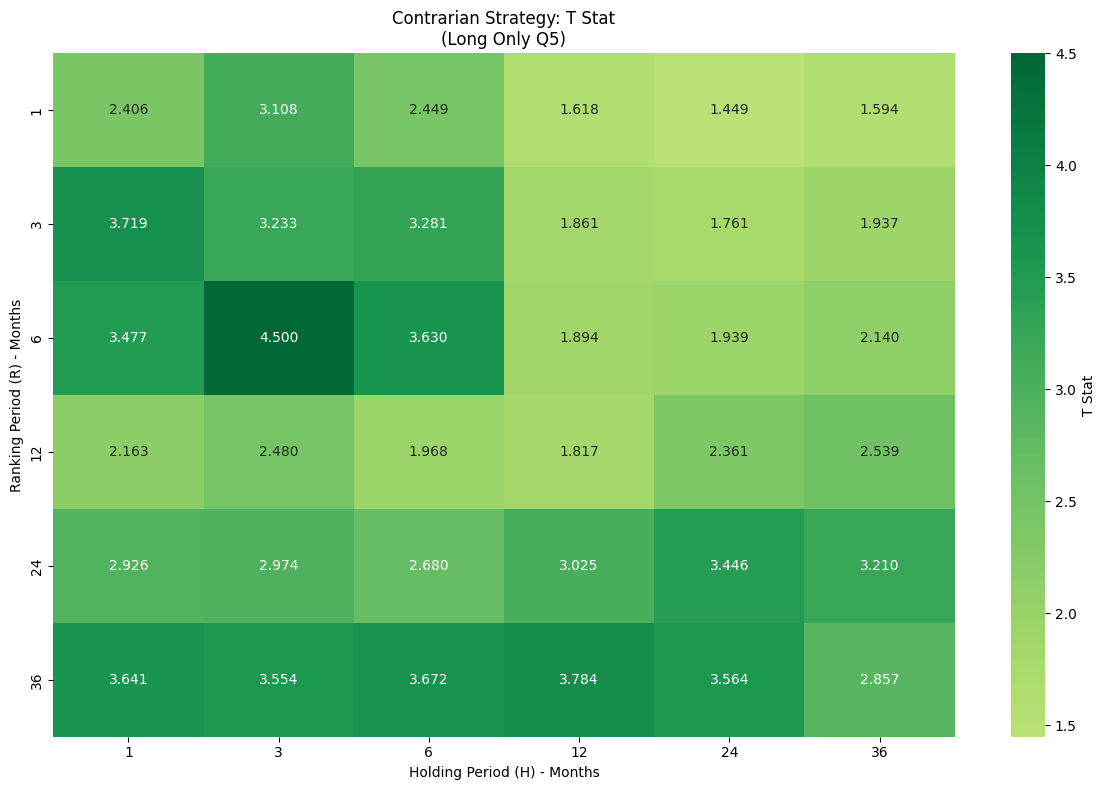

In [14]:
def plot_heatmap(summary_df: pd.DataFrame, metric: str = 'sharpe', 
                strategy: str = 'Momentum', portfolio_type: str = 'long_short'):
    """Plot heatmap of performance metric across R and H dimensions."""
    
    # Filter data
    data = summary_df[
        (summary_df['Strategy'] == strategy) & 
        (summary_df['Portfolio_Type'] == portfolio_type)
    ].copy()
    
    if data.empty:
        print(f"No data for {strategy} {portfolio_type}")
        return
    
    # Pivot for heatmap
    heatmap_data = data.pivot(index='R', columns='H', values=metric)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Color map
    if metric in ['sharpe', 'ann_return', 'calmar', 't_stat']:
        cmap = 'RdYlGn'
    else:
        cmap = 'RdYlGn_r'
    
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.3f',
        cmap=cmap,
        center=0 if metric in ['ann_return', 't_stat'] else None,
        cbar_kws={'label': metric.replace('_', ' ').title()}
    )
    
    plt.title(f'{strategy} Strategy: {metric.replace("_", " ").title()}\n({portfolio_type.replace("_", " ").title()})')
    plt.xlabel('Holding Period (H) - Months')
    plt.ylabel('Ranking Period (R) - Months')
    plt.tight_layout()
    plt.show()

# Generate heatmaps
for mode in CONFIG['strategies']:
    for portfolio_type in ['long_short', 'long_only_q5']:
        print(f"\n📊 {mode.title()} - {portfolio_type.replace('_', ' ').title()} - Sharpe Ratio")
        plot_heatmap(summary_df, metric='sharpe', strategy=mode.title(), portfolio_type=portfolio_type)
        
        print(f"\n🧮 {mode.title()} - {portfolio_type.replace('_', ' ').title()} - t-statistic")
        plot_heatmap(summary_df, metric='t_stat', strategy=mode.title(), portfolio_type=portfolio_type)

📈 EQUITY CURVES FOR TOP 5 STRATEGIES


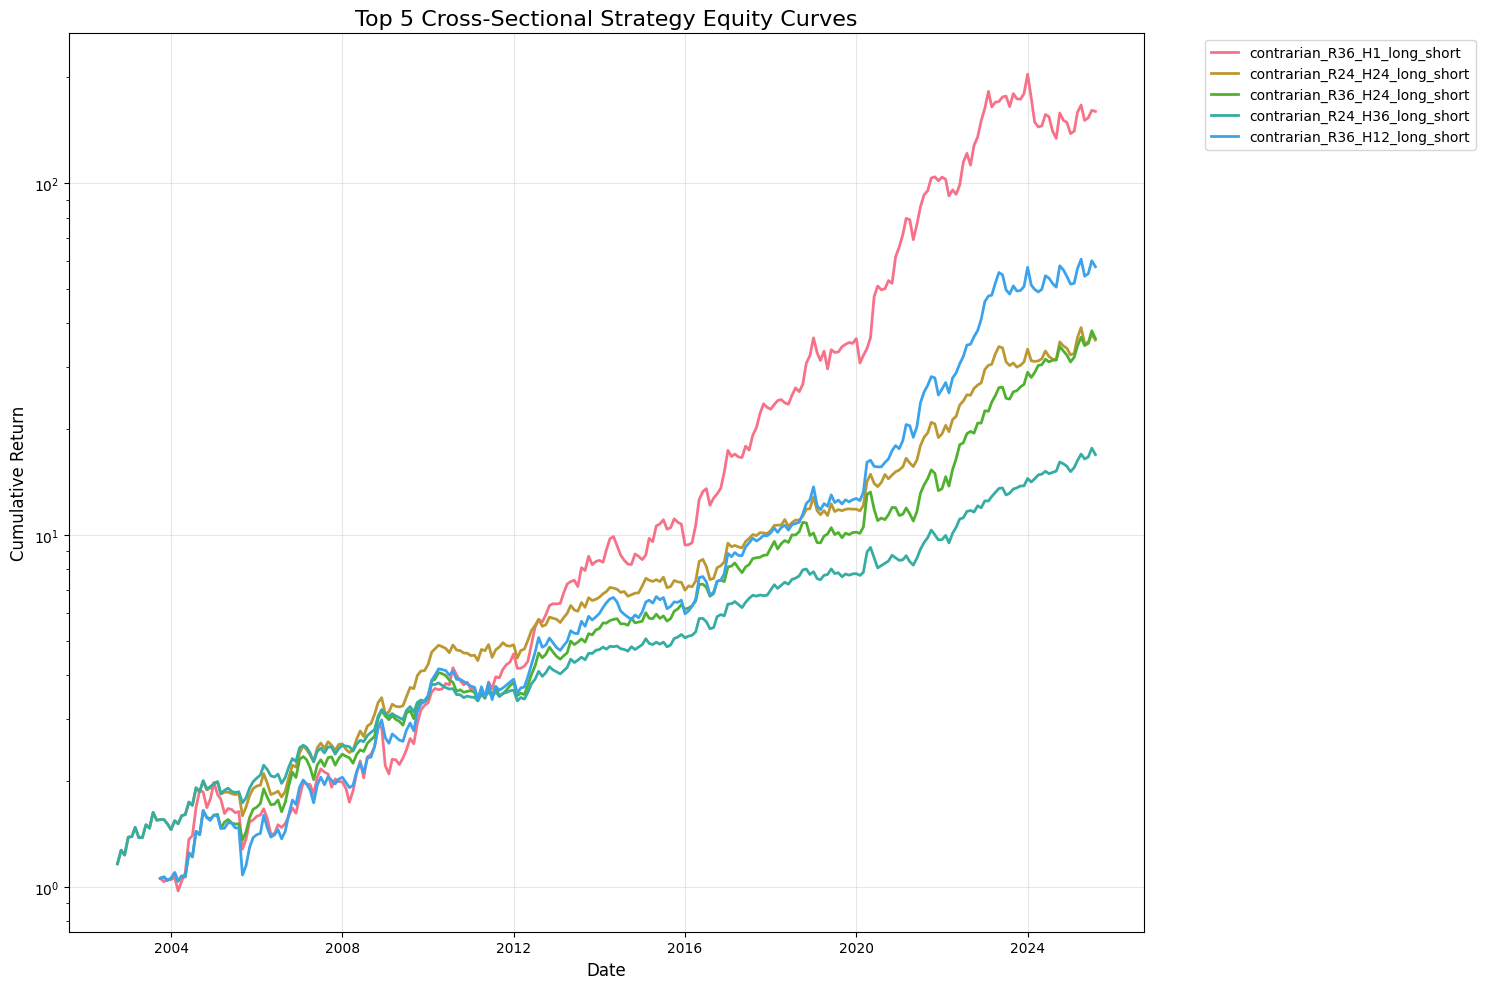

In [15]:
# Equity curves for top strategies
print("📈 EQUITY CURVES FOR TOP 5 STRATEGIES")

plt.figure(figsize=(15, 10))

top_5_strategies = summary_df.nlargest(5, 'sharpe')['Strategy_Key'].tolist()

for i, strategy_name in enumerate(top_5_strategies):
    if strategy_name in detailed_results:
        returns = detailed_results[strategy_name]
        equity_curve = (1 + returns.fillna(0)).cumprod()
        
        plt.plot(equity_curve.index, equity_curve.values, 
                label=strategy_name, linewidth=2)

plt.title('Top 5 Cross-Sectional Strategy Equity Curves', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

📊 RETURN DISTRIBUTION: contrarian_R36_H1_long_short


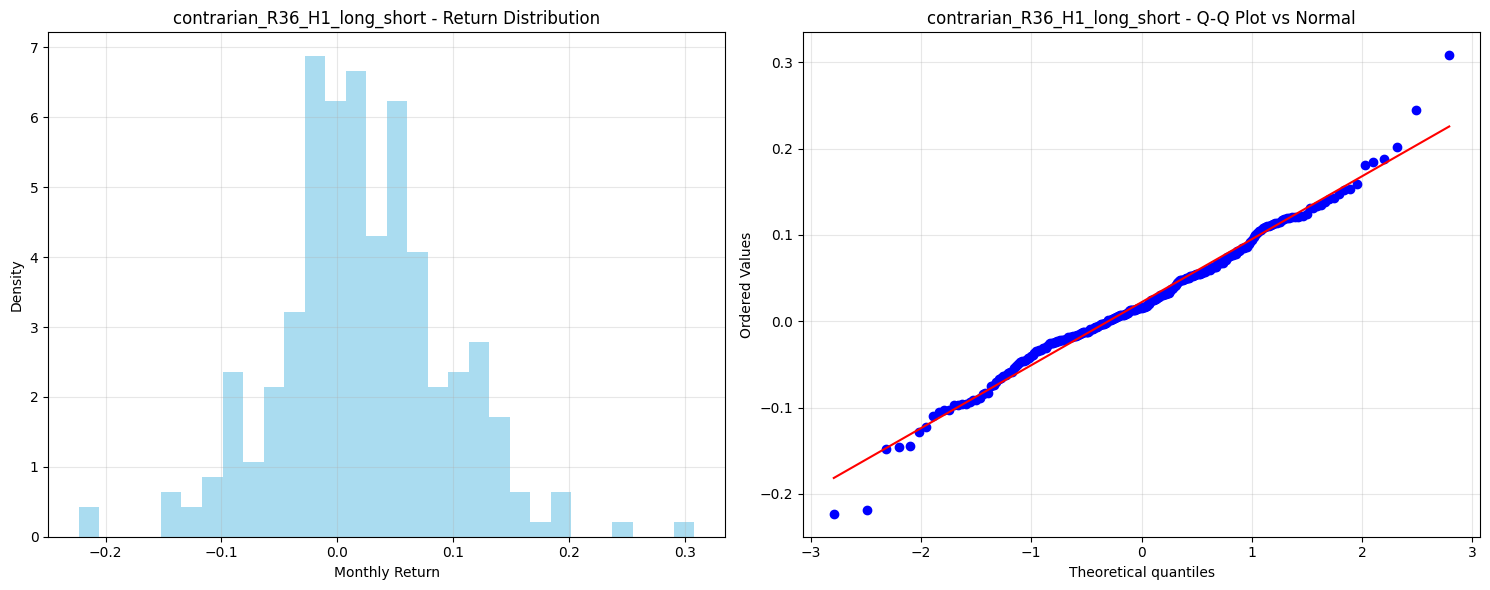


🧪 Normality Tests for contrarian_R36_H1_long_short:
   Shapiro-Wilk: stat=0.9872, p-value=0.0197
   Jarque-Bera: stat=14.9840, p-value=0.0006
   Skewness: 0.0862
   Kurtosis: 1.1566


In [16]:
# Return distribution for best strategy
if not summary_df['sharpe'].isna().all():
    best_strategy = summary_df.loc[summary_df['sharpe'].idxmax(), 'Strategy_Key']
    
    if best_strategy in detailed_results:
        best_returns = detailed_results[best_strategy]
        
        print(f"📊 RETURN DISTRIBUTION: {best_strategy}")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Histogram
        ax1.hist(best_returns.dropna(), bins=30, alpha=0.7, density=True, color='skyblue')
        ax1.set_title(f'{best_strategy} - Return Distribution')
        ax1.set_xlabel('Monthly Return')
        ax1.set_ylabel('Density')
        ax1.grid(True, alpha=0.3)
        
        # Q-Q plot
        stats.probplot(best_returns.dropna(), dist="norm", plot=ax2)
        ax2.set_title(f'{best_strategy} - Q-Q Plot vs Normal')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests
        returns_clean = best_returns.dropna()
        if len(returns_clean) > 7:
            shapiro_stat, shapiro_p = stats.shapiro(returns_clean)
            jb_stat, jb_p = stats.jarque_bera(returns_clean)
            
            print(f"\n🧪 Normality Tests for {best_strategy}:")
            print(f"   Shapiro-Wilk: stat={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
            print(f"   Jarque-Bera: stat={jb_stat:.4f}, p-value={jb_p:.4f}")
            print(f"   Skewness: {stats.skew(returns_clean):.4f}")
            print(f"   Kurtosis: {stats.kurtosis(returns_clean):.4f}")

## 💾 Save Results

In [17]:
# Create output directories
output_dir = Path('./results')
output_dirs = {
    'results': output_dir,
    'series': output_dir / 'series',
    'figures': output_dir / 'figures',
    'summary': output_dir / 'summary'
}

for dir_path in output_dirs.values():
    dir_path.mkdir(parents=True, exist_ok=True)

print("💾 Saving results...")

# Save summary table
summary_df.to_csv(output_dirs['summary'] / 'strategy_summary.csv', index=False)
print(f"✅ Summary saved: {output_dirs['summary'] / 'strategy_summary.csv'}")

# Save individual strategy time series
for strategy_key, returns in detailed_results.items():
    clean_key = strategy_key.replace(' ', '_').replace('-', '_')
    
    # Save returns
    returns.to_csv(output_dirs['series'] / f'{clean_key}_returns.csv')
    
    # Save equity curve
    equity_curve = (1 + returns.fillna(0)).cumprod()
    equity_curve.to_csv(output_dirs['series'] / f'{clean_key}_equity.csv')

print(f"✅ Time series saved: {len(detailed_results)} strategies")

# Save metadata
metadata = {
    'generated_at': datetime.now().isoformat(),
    'config': CONFIG,
    'data_summary': {
        'start_date': monthly_returns.index.min().isoformat(),
        'end_date': monthly_returns.index.max().isoformat(),
        'n_months': len(monthly_returns),
        'n_commodities': len(monthly_returns.columns),
        'commodities': monthly_returns.columns.tolist()
    },
    'results_summary': {
        'total_combinations': len(summary_df),
        'valid_strategies': len(summary_df[~summary_df['sharpe'].isna()]),
        'best_strategy': summary_df.loc[summary_df['sharpe'].idxmax(), 'Strategy_Key'] if not summary_df['sharpe'].isna().all() else 'N/A',
        'best_sharpe': float(summary_df['sharpe'].max()) if not summary_df['sharpe'].isna().all() else np.nan
    }
}

with open(output_dirs['summary'] / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"✅ Metadata saved: {output_dirs['summary'] / 'metadata.json'}")
print(f"📁 All results saved to: {output_dir}")

💾 Saving results...
✅ Summary saved: results/summary/strategy_summary.csv
✅ Time series saved: 216 strategies
✅ Metadata saved: results/summary/metadata.json
📁 All results saved to: results


# =============================================================================
# SAVE RESULTS (Only if data and results are valid)
# =============================================================================

if 'data_valid' in locals() and data_valid and 'summary_df' in locals() and len(summary_df) > 0:
    
    # Create output directories
    output_dir = Path('./results')
    output_dirs = {
        'results': output_dir,
        'series': output_dir / 'series',
        'figures': output_dir / 'figures',
        'summary': output_dir / 'summary'
    }

    for dir_path in output_dirs.values():
        dir_path.mkdir(parents=True, exist_ok=True)

    print("💾 Saving results...")

    # Save summary table
    summary_df.to_csv(output_dirs['summary'] / 'strategy_summary.csv', index=False)
    print(f"✅ Summary saved: {output_dirs['summary'] / 'strategy_summary.csv'}")

    # Save individual strategy time series
    for strategy_key, returns in detailed_results.items():
        clean_key = strategy_key.replace(' ', '_').replace('-', '_')
        
        # Save returns
        returns.to_csv(output_dirs['series'] / f'{clean_key}_returns.csv')
        
        # Save equity curve
        equity_curve = (1 + returns.fillna(0)).cumprod()
        equity_curve.to_csv(output_dirs['series'] / f'{clean_key}_equity.csv')

    print(f"✅ Time series saved: {len(detailed_results)} strategies")

    # Save metadata
    metadata = {
        'generated_at': datetime.now().isoformat(),
        'config': CONFIG,
        'data_summary': {
            'start_date': monthly_returns.index.min().isoformat(),
            'end_date': monthly_returns.index.max().isoformat(),
            'n_months': len(monthly_returns),
            'n_commodities': len(monthly_returns.columns),
            'commodities': monthly_returns.columns.tolist()
        },
        'results_summary': {
            'total_combinations': len(summary_df),
            'valid_strategies': len(summary_df[~summary_df['sharpe'].isna()]),
            'best_strategy': summary_df.loc[summary_df['sharpe'].idxmax(), 'Strategy_Key'] if not summary_df['sharpe'].isna().all() else 'N/A',
            'best_sharpe': float(summary_df['sharpe'].max()) if not summary_df['sharpe'].isna().all() else np.nan
        }
    }

    with open(output_dirs['summary'] / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2, default=str)

    print(f"✅ Metadata saved: {output_dirs['summary'] / 'metadata.json'}")
    print(f"📁 All results saved to: {output_dir}")

else:
    print("⚠️ Skipping save - no valid data or results to save")
    if 'summary_df' in locals() and len(summary_df) > 0:
        print("💡 Results exist but data validation failed")
    else:
        print("💡 No results generated")

In [18]:
print("\n" + "=" * 60)
print("📋 FINAL SUMMARY")
print("=" * 60)

print(f"⏰ Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📅 Data period: {monthly_returns.index.min().date()} to {monthly_returns.index.max().date()}")
print(f"📊 Total months: {len(monthly_returns)}")
print(f"🎯 Commodities analyzed: {len(monthly_returns.columns)}")
print(f"🔄 Strategy combinations: {len(summary_df)}")
print(f"✅ Valid strategies: {len(summary_df[~summary_df['sharpe'].isna()])}")

if not summary_df['sharpe'].isna().all():
    best_strategy = summary_df.loc[summary_df['sharpe'].idxmax(), 'Strategy_Key']
    best_sharpe = summary_df['sharpe'].max()
    best_return = summary_df.loc[summary_df['sharpe'].idxmax(), 'ann_return']
    
    print(f"\n🏆 BEST STRATEGY: {best_strategy}")
    print(f"   📈 Sharpe Ratio: {best_sharpe:.3f}")
    print(f"   📊 Annual Return: {best_return:.2%}")

# Asset coverage report
print(f"\n📊 Asset Coverage:")
for ticker in monthly_returns.columns:
    non_null_pct = (1 - monthly_returns[ticker].isna().mean()) * 100
    print(f"   {ticker}: {non_null_pct:.1f}%")

print(f"\n💾 Results saved to: {output_dir}/")
print("✅ ANALYSIS COMPLETED SUCCESSFULLY!")
print("\n📖 Next steps:")
print("   1. Review summary table: results/summary/strategy_summary.csv")
print("   2. Analyze time series: results/series/")
print("   3. Check metadata: results/summary/metadata.json")
print("   4. Consider transaction costs and regime changes")
print("   5. Implement risk management overlays")


📋 FINAL SUMMARY
⏰ Analysis completed at: 2025-08-10 16:17:53
📅 Data period: 2000-09-30 to 2025-07-31
📊 Total months: 299
🎯 Commodities analyzed: 27
🔄 Strategy combinations: 216
✅ Valid strategies: 216

🏆 BEST STRATEGY: contrarian_R36_H1_long_short
   📈 Sharpe Ratio: 1.048
   📊 Annual Return: 26.52%

📊 Asset Coverage:
   CL=F: 100.0%
   BZ=F: 72.2%
   NG=F: 100.0%
   RB=F: 99.0%
   HO=F: 99.7%
   GC=F: 100.0%
   SI=F: 100.0%
   HG=F: 100.0%
   PL=F: 91.0%
   PA=F: 96.0%
   ZC=F: 100.0%
   ZW=F: 100.0%
   KE=F: 99.7%
   ZS=F: 99.7%
   ZM=F: 100.0%
   ZL=F: 100.0%
   ZO=F: 98.7%
   KC=F: 100.0%
   SB=F: 100.0%
   CC=F: 100.0%
   CT=F: 100.0%
   OJ=F: 95.7%
   LE=F: 97.0%
   HE=F: 98.7%
   GF=F: 97.3%
   DC=F: 77.3%
   LBS=F: 91.3%

💾 Results saved to: results/
✅ ANALYSIS COMPLETED SUCCESSFULLY!

📖 Next steps:
   1. Review summary table: results/summary/strategy_summary.csv
   2. Analyze time series: results/series/
   3. Check metadata: results/summary/metadata.json
   4. Consider transa

print("\n" + "=" * 60)
print("📋 FINAL SUMMARY")
print("=" * 60)

print(f"⏰ Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if 'monthly_returns' in locals() and monthly_returns is not None:
    print(f"📅 Data period: {monthly_returns.index.min().date()} to {monthly_returns.index.max().date()}")
    print(f"📊 Total months: {len(monthly_returns)}")
    print(f"🎯 Commodities analyzed: {len(monthly_returns.columns)}")
    
    if 'summary_df' in locals() and len(summary_df) > 0:
        print(f"🔄 Strategy combinations: {len(summary_df)}")
        print(f"✅ Valid strategies: {len(summary_df[~summary_df['sharpe'].isna()])}")

        if not summary_df['sharpe'].isna().all():
            best_strategy = summary_df.loc[summary_df['sharpe'].idxmax(), 'Strategy_Key']
            best_sharpe = summary_df['sharpe'].max()
            best_return = summary_df.loc[summary_df['sharpe'].idxmax(), 'ann_return']
            
            print(f"\n🏆 BEST STRATEGY: {best_strategy}")
            print(f"   📈 Sharpe Ratio: {best_sharpe:.3f}")
            print(f"   📊 Annual Return: {best_return:.2%}")

        # Asset coverage report
        print(f"\n📊 Asset Coverage:")
        for ticker in monthly_returns.columns:
            non_null_pct = (1 - monthly_returns[ticker].isna().mean()) * 100
            print(f"   {ticker}: {non_null_pct:.1f}%")
            
        print(f"\n💾 Results saved to: results/")
        print("✅ ANALYSIS COMPLETED SUCCESSFULLY!")
        print("\n📖 Next steps:")
        print("   1. Review summary table: results/summary/strategy_summary.csv")
        print("   2. Analyze time series: results/series/")
        print("   3. Check metadata: results/summary/metadata.json")
        print("   4. Consider transaction costs and regime changes")
        print("   5. Implement risk management overlays")
    else:
        print("❌ No strategy results generated")
        print("💡 Check data validation and grid search execution")
else:
    print("❌ No data available for analysis")
    print("💡 Make sure to run the data download section first")